In [1]:
%matplotlib inline
%config InlineBackend.figure_format = "retina"

In [2]:
import matplotlib.pyplot as plt
from matplotlib import rcParams
rcParams["savefig.dpi"] = 100
rcParams["figure.dpi"] = 100
rcParams["figure.figsize"] = 12, 4
rcParams["font.size"] = 16
rcParams["text.usetex"] = False
rcParams["font.family"] = ["sans-serif"]
rcParams["font.sans-serif"] = ["cmss10"]
rcParams["axes.unicode_minus"] = False

In [3]:
import numpy as np
import pymc3 as pm
import exoplanet as xo
import starry
import theano
import theano.tensor as tt
np.random.seed(42)

In [4]:
# True values
truths = {
    "inc":      75.0,
    "obl":      30.0,
    "alpha":    0.40,
    "veq":      3.00,
    "period":   10.0,
    "t0":       0.0,
    "b":        0.25,
    "ro":        0.1,
    "u":        [0.4, 0.26],
    "rv_err":   0.0005
}

# Generate a synthetic dataset
t = np.linspace(-0.15, 0.15, 100)
udeg = len(truths["u"])
map = starry.DopplerMap(udeg=udeg)
map[1:] = truths["u"]
map.inc = truths["inc"]
map.obl = truths["obl"]
map.alpha = truths["alpha"]
map.veq = truths["veq"]
orbit = xo.orbits.KeplerianOrbit(period=truths["period"], 
                                 t0=truths["t0"], b=truths["b"])
truths["rv"] = map.rv_op(t=t, orbit=orbit, ro=truths["ro"]).eval()
rv = truths["rv"] + truths["rv_err"] * np.random.randn(len(t))

In [5]:
# Define our model
map = starry.DopplerMap(udeg=udeg)
with pm.Model() as model:

    # Things we're fixing
    map.inc = truths["inc"]
    map.obl = truths["obl"]
    period = truths["period"]
    t0 = truths["t0"]
    b = truths["b"]
    
    # Priors on the things we're solving for
    alpha = pm.Uniform("alpha", 0.0, 1.0)
    veq = pm.Uniform("veq", 0.0, 10.0)
    u = xo.distributions.QuadLimbDark("u", testval=np.array([0.3, 0.2]))
    ro = pm.Uniform("ro", 0.01, 0.25)

    # Set up a Keplerian orbit for the planet
    orbit = xo.orbits.KeplerianOrbit(period=period, t0=t0, b=b)

    # Compute the model light curve using starry
    rv_model = map.rv_op(u=u, veq=veq, t=t, orbit=orbit, ro=ro, alpha=alpha)

    # Here we track the value of the model light curve for plotting later
    pm.Deterministic("rv_model", rv_model)

    # Save our initial guess
    model_guess = xo.eval_in_model(rv_model)

    # The likelihood function assuming known Gaussian uncertainty
    pm.Normal("obs", mu=rv_model, sd=truths["rv_err"], observed=rv)

    # Fit for the maximum a posteriori parameters
    map_soln = xo.optimize(start=model.test_point)

success: True
initial logp: -53503.86359129918
final logp: 621.0258118012324


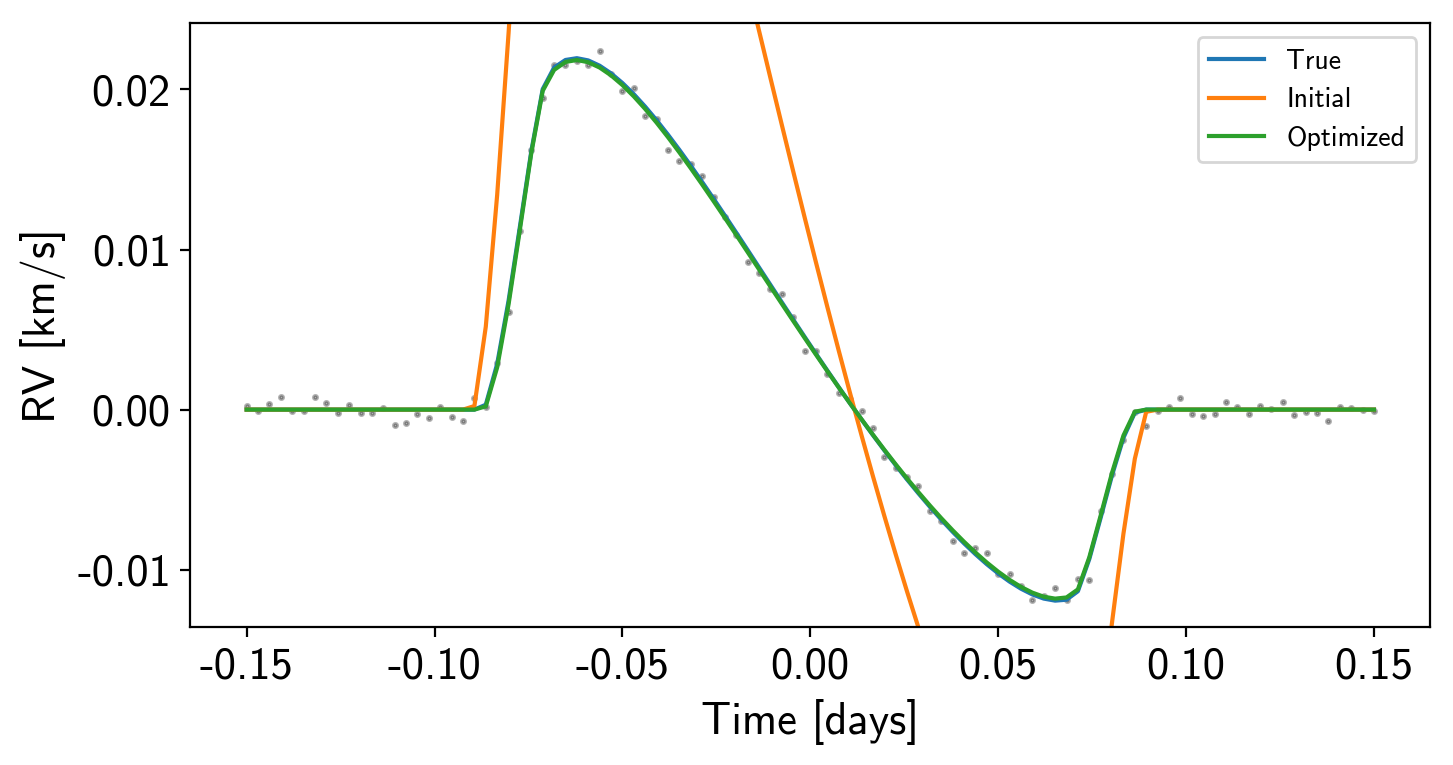

In [6]:
# Plot it
fig, ax = plt.subplots(1, figsize=(8, 4))
ax.plot(t, rv, 'k.', alpha=0.3, ms=3)
ax.set_ylim(*ax.get_ylim())
ax.plot(t, truths["rv"], label="True")
ax.plot(t, model_guess, label="Initial")
ax.plot(t, map_soln["rv_model"], label="Optimized")
ax.legend(fontsize=10)
ax.set_xlabel("Time [days]")
ax.set_ylabel("RV [km/s]");

In [7]:
# Sample it
sampler = xo.PyMC3Sampler(window=100, finish=200)
with model:
    burnin = sampler.tune(tune=2500, start=map_soln, step_kwargs=dict(target_accept=0.9))
    trace = sampler.sample(draws=3000)

Sampling 4 chains: 100%|██████████| 808/808 [00:09<00:00, 87.33draws/s] 
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ro, u, veq, alpha]
Sampling 4 chains: 100%|██████████| 12000/12000 [02:40<00:00, 74.78draws/s]
The acceptance probability does not match the target. It is 0.9620485816387911, but should be close to 0.9. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9605911950736977, but should be close to 0.9. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9615504742137946, but should be close to 0.9. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9632933712065939, but should be close to 0.9. Try to increase the number of tuning steps.


In [8]:
pm.summary(trace, varnames=["alpha", "veq", "u", "ro"])

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
alpha,0.405935,0.023149,0.000214,0.361292,0.452757,9595.215787,1.000000
veq,3.208763,0.372441,0.006542,2.552159,3.966672,3189.161134,1.000907
u__0,0.334948,0.092376,0.001098,0.149847,0.511041,8160.611230,1.000049
u__1,0.354464,0.121405,0.001351,0.116966,0.593127,8519.201580,1.000042
ro,0.096674,0.005522,0.000094,0.085848,0.107171,3314.227049,1.000942


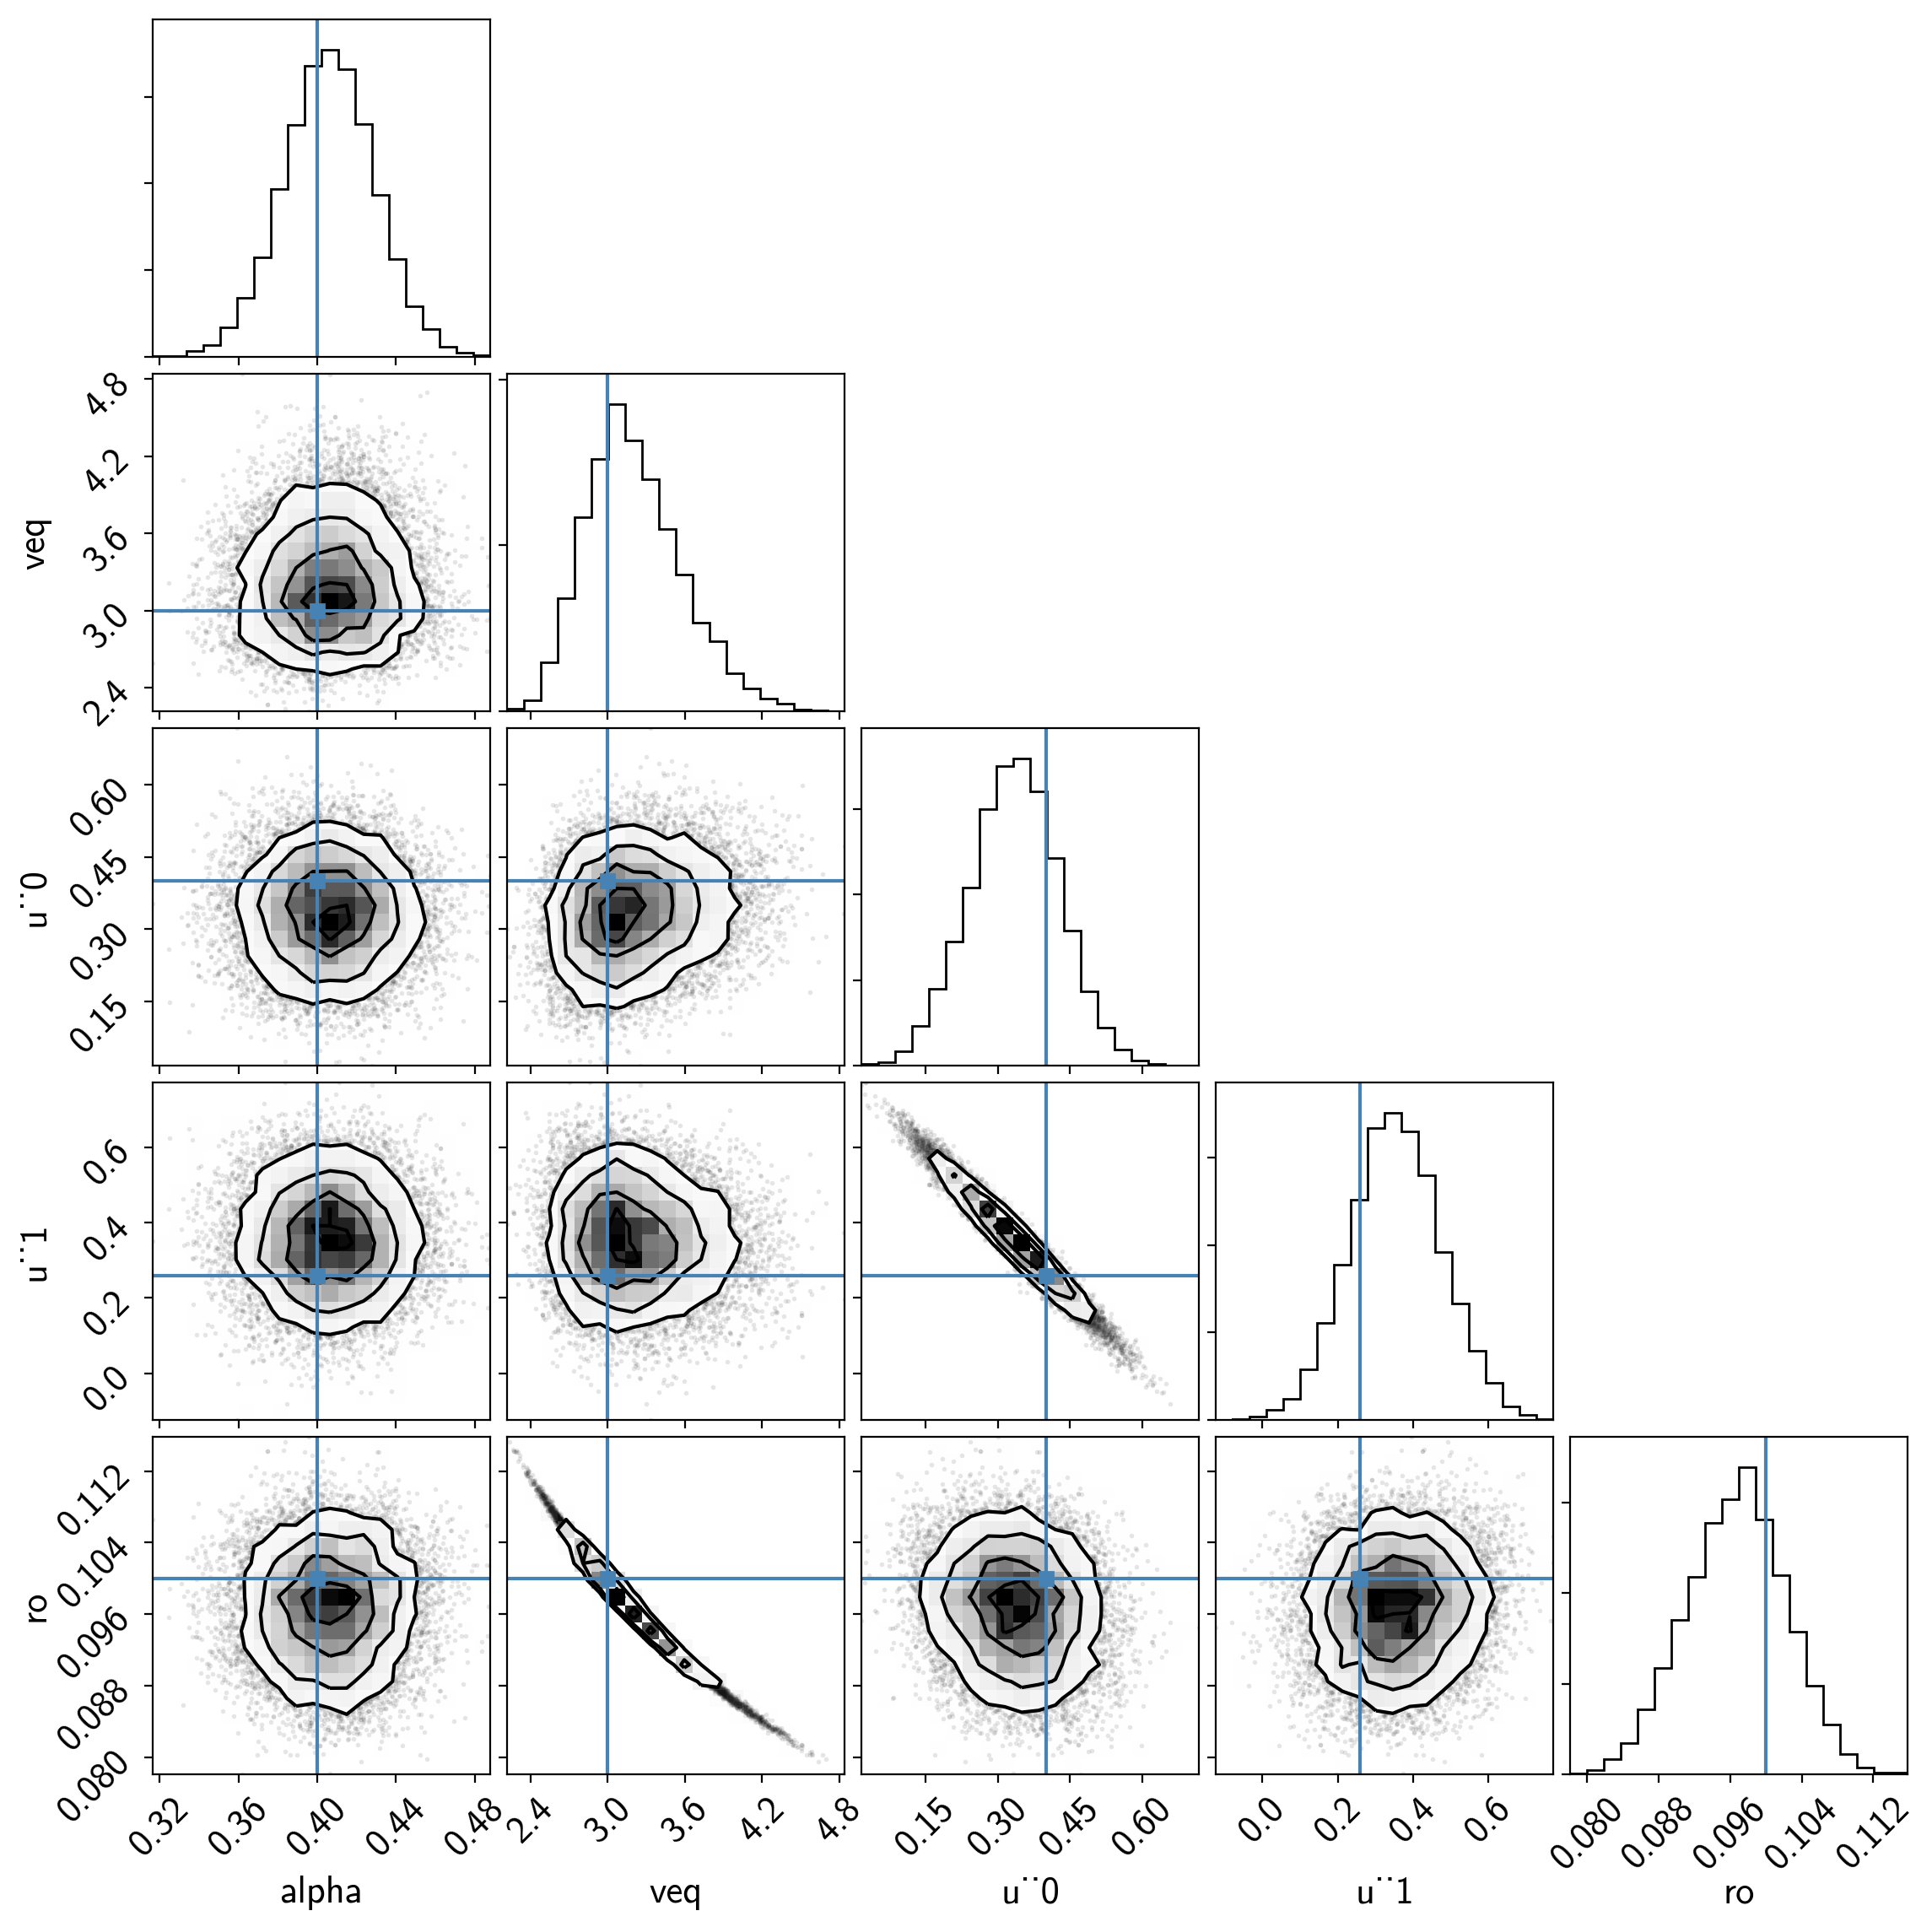

In [9]:
import corner
samples = pm.trace_to_dataframe(trace, varnames=["alpha", "veq", "u", "ro"])
corner.corner(samples, truths=[truths["alpha"], truths["veq"], truths["u"][0], truths["u"][1], truths["ro"]]);